# <center> <font style="color:rgb(100,109,254)"> Gender Detection with DNN </font> </center>


In [1]:
# Import required packages.
import bleedfacedetector as fd
import cv2
import numpy as np
import time
import os
from tkinter import filedialog
from tkinter import Tk
import matplotlib.pyplot as plt

## <font style="color:rgb(134,19,348)"> Initialize the DNN module </font>

In [2]:
proto_file = "Media/M4/Model/gender_deploy.prototxt"
weights = "Media/M4/Model/gender_net.caffemodel"

net = cv2.dnn.readNet(weights,proto_file)

##  <font style="color:rgb(134,19,348)">Read Image</font> 


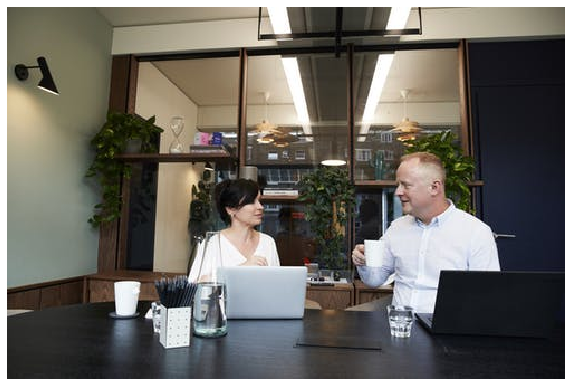

In [3]:
# Read image
image = cv2.imread("Media/M4/Gender.jpeg")

# Display image
plt.figure(figsize=[10,10]);
plt.imshow(image[:,:,::-1]);
plt.axis('off');

**We'll be predicting among these Genders.**

In [4]:
# Define Gender List
Genders= ['Male', 'Female']

##  <font style="color:rgb(134,19,348)">Detect Faces with bleedfacedetector</font> 

Lets see the Age Detection Operation for a single face. Then we can apply the same procedure to multiple faces.

In [5]:
img_copy = image.copy()

# Use SSD detector with 20% confidence threshold.
faces = fd.ssd_detect(img_copy, conf=0.2)

# Check the number detected faces in image
print("{} faces detected".format(len(faces)))

# Lets take coordinates of the first face in the image. 
x,y,w,h = faces[0]

# Define padding for face roi
padding = 3

# extract the Face from image with padding.
face = img_copy[y-padding:y+h+padding,x-padding:x+w+padding] 

2 faces detected


## <font style="color:rgb(134,19,348)"> Pre-processing the image 
</font>

In [6]:
# Prepare the frame to be fed to the network
blob  = cv2.dnn.blobFromImage(face, 1, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), swapRB=False)

## <font style="color:rgb(134,19,348)"> Input the Blob Image to the Network  </font>


In [7]:
net.setInput(blob)

##  <font style="color:rgb(134,19,348)">Forward Pass</font> 


In [8]:
%%time
output = net.forward()

Wall time: 20 ms


In [9]:
# The output are the probabilities for each Gender
print('Shape of Output: {} \n'.format(output.shape))
print(output)

Shape of Output: (1, 2) 

[[0.9964819  0.00351806]]


In [10]:
# Get the index of the max probability and that's your Gender
print('Predicted Gender is : {}'.format(Genders[output[0].argmax()]))

Predicted Gender is : Male


##  <font style="color:rgb(134,19,348)">Iterate the Process for all faces</font> 


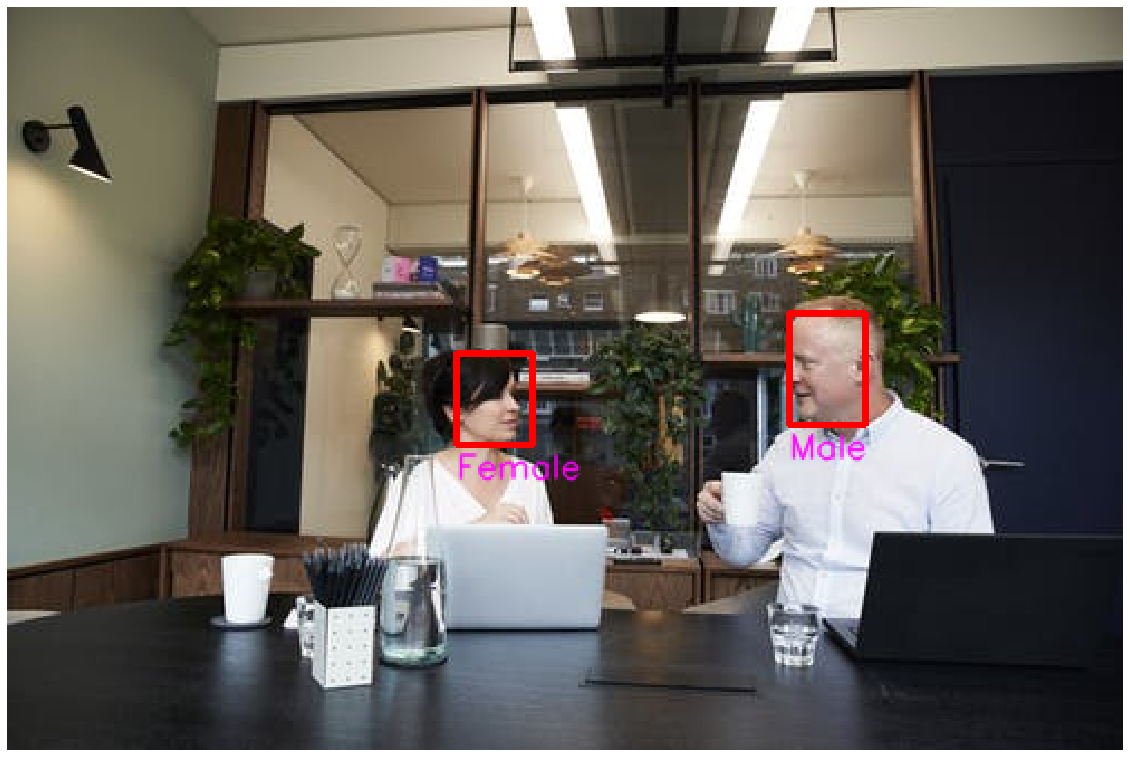

In [11]:
img_copy = image.copy()
padding = 3 
for x,y,w,h in faces:
    face = img_copy[y-padding:y+h+padding,x-padding:x+w+padding]
    blob = cv2.dnn.blobFromImage(face, 1, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
    net.setInput(blob)
    s1= time.time()
    output = net.forward()
    predicted_gender = Genders[output[0].argmax()]
    cv2.putText(img_copy,'{}'.format(predicted_gender),(x,y+h+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255), 1, cv2.LINE_AA)
    cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,0,255),2)
plt.figure(figsize=(20,20))
plt.imshow(img_copy[:,:,::-1]);plt.axis("off");

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [12]:
def init_detectgender(usegpu = 'None',weights_name="gender_net.caffemodel",proto_name="gender_deploy.prototxt"):
    
    # Set global variables
    global net,Genders
    
    # Defining base path
    base_path = 'Media/M4/Model'
    
    # Defining model paths
    proto_file = os.path.join(base_path, proto_name)
    weights = os.path.join(base_path, weights_name) 
    
    # Initialize the DNN module
    net = cv2.dnn.readNet(weights,proto_file)
    
    # Define Gender List
    Genders= ['Male', 'Female']
    
    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [13]:
def detectgender(image=[], usercam=False,returndata=False,padding=3,face_conf=0.2):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame=cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()
                
        # Otherwise select image from computer using tkinter        
        else:
            root = Tk()
            root.filename =  filedialog.askopenfilename(title = "Pick up the Image")
            root.withdraw()
            image = cv2.imread(root.filename)
    
    img_copy = image.copy()

    # Use SSD detector with 20% confidence threshold.
    faces = fd.ssd_detect(img_copy, conf=face_conf)

    # Lets take coordinates of the first face in the image. 
    x,y,w,h = faces[0]

    # Define padding for face roi
    padding = 3

    # extract the Face from image with padding.
    face = img_copy[y-padding:y+h+padding,x-padding:x+w+padding] 
    
    # Prepare the frame to be fed to the network
    blob  = cv2.dnn.blobFromImage(face, 1, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
    
    net.setInput(blob)
    output = net.forward()
    
    padding = 3 
    for x,y,w,h in faces:
        face = img_copy[y-padding:y+h+padding,x-padding:x+w+padding]
        blob = cv2.dnn.blobFromImage(face, 1, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
        net.setInput(blob)
        s1= time.time()
        output = net.forward()
        predicted_gender = Genders[output[0].argmax()]
        cv2.putText(img_copy,'{}'.format(predicted_gender),(x,y+h+50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,255), 2, cv2.LINE_AA)
        cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,0,255),2)
    
    if  returndata:
        return img_copy
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(img_copy[:,:,::-1]);plt.axis("off");          

**Initialize the Gender Detector**

In [14]:
init_detectgender()

**Calling Gender Detector with default arguments.**

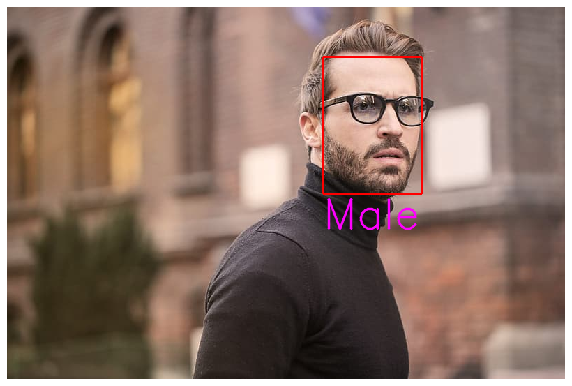

In [15]:
image = cv2.imread("Media/M4/male3.jpg")
detectgender(image)

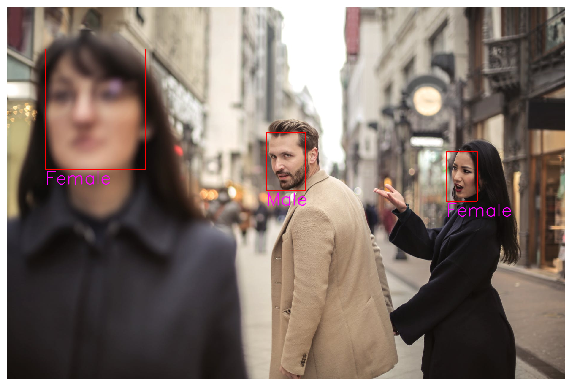

In [16]:
image = cv2.imread("Media/M4/2.jpeg")
detectgender(image)

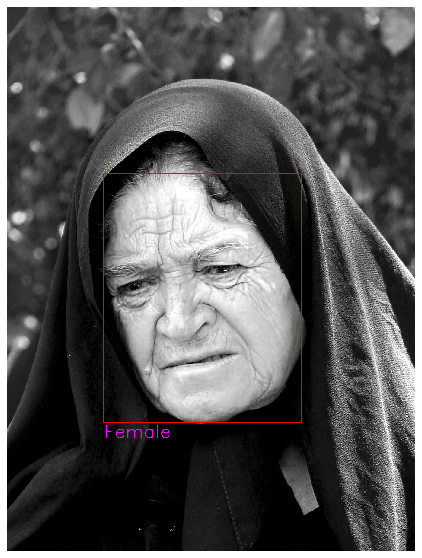

In [17]:
image = cv2.imread("Media/M4/sad2.jpg")
detectgender(image,face_conf=0.9)

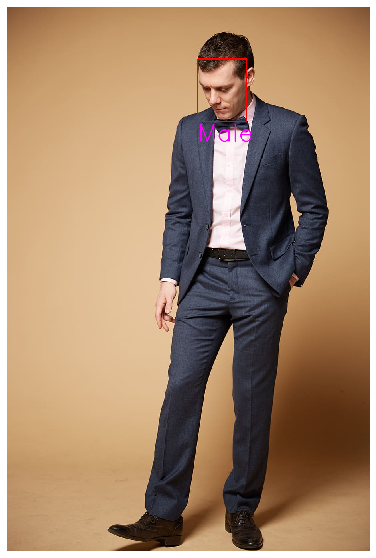

In [18]:
image = cv2.imread("Media/M4/man6.jpg")
detectgender(image)

####  Capturing Image from Camera

In [ ]:
detectgender(usercam=True)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [20]:
init_detectgender()

In [21]:
%%time
image= detectgender(image = image, returndata=True)

Wall time: 197 ms


**Intel GPU**

In [22]:
init_detectgender(usegpu = 'opencl')

In [23]:
%%time
image= detectgender(image = image, returndata=True)

Wall time: 2.44 s


**NVIDIA GPU**

In [24]:
init_detectgender(usegpu = 'cuda')

In [25]:
%%time
image= detectgender(image = image, returndata=True)

Wall time: 171 ms


## <font style="color:rgb(134,19,348)"> Gender Detection with Live webcam </font>

In [ ]:
fps=0
init_detectgender()
cap=cv2.VideoCapture(0)

while(True):    
    
    start_time = time.time()
    ret,frame=cap.read() 
    image=cv2.flip(frame,1)
    
    image = detectgender(image,returndata=True)
    
    cv2.putText(image, 'FPS: {:.2f}'.format(fps), (400, 20), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 20, 55), 2)
    cv2.imshow("Gender Detection",image)
    
    k = cv2.waitKey(1)
    fps= (1.0 / (time.time() - start_time))
    
    if k == ord('q'):
        break
cap.release() 
cv2.destroyAllWindows() 